# Solution Assignment 7: Policy Gradients
This is the solution for the seventh assignment of the Implementing Artificial Neural Networks with TensorFlow course. Please find the according assignment sheet on studip. In this assignment, we train a reinforcement learning agent with the policy gradients to perform the _cart pole_ task.

## Imports
We are going to use OpenAi's `gym` library to generate an environment that we can use to train our reinforcement learning agent. Further, `tensorflow` is going to be used to implement the neural network, `numpy` for numerical operations outside of the computational graph and `matplotlib` to plot the training process. Finally, we activate inline plotting by calling `%matplotlib notebook`.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym


%matplotlib notebook

ImportError: Traceback (most recent call last):
  File "C:\Users\Jonathan\Anaconda3\envs\OpenAI\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\Jonathan\Anaconda3\envs\OpenAI\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 18, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\Jonathan\Anaconda3\envs\OpenAI\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 17, in swig_import_helper
    return importlib.import_module(mname)
  File "C:\Users\Jonathan\Anaconda3\envs\OpenAI\lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
ImportError: DLL load failed: Das angegebene Modul wurde nicht gefunden.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

## Helperfunction

This helper class is used for the creation of the fully-connected feed-forward layers of the network. It is used to map the game state onto the hidden layer and to map the hidden state onto the final output neuron.

In [3]:
def feed_forward_layer(x, target_size, activation_function = None):
    print("Forward-Layer:" + str(x.shape))
    
    fan_in = int(x.shape[-1])
    
    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [target_size], tf.float32, var_init)
    
    activation = tf.matmul(x, weights) + biases
    
    return activation_function(activation) if callable(activation_function) else activation

    

## Hyperparameters

The network's hidden layer has 8 neurons. The initial learning rate is 0.025 and we exponentially decay it with a decay rate of 0.8. The discount factor is 0.99 and hence our agent is very far-sighted. Parameters are updated after every 10 rounds of playing and in total, we play 400 rounds of cart pole.

In [4]:
hidden_layer_size = 8

initial_learning_rate = 0.05
decay_steps = 100
decay_rate = 0.75

discount_factor = 0.99

batch_size = 10
training_episodes = 400 // batch_size

## Construction phase

Next, the computational graph of the network is created. Each observation is mapped onto a hidden layer with 8 hidden neurons. In a second and final layer, the hidden state is mapped onto a single output neuron with sigmoid activation function. This neuron indicates the probability of moving the cart towards the right.

![PICTURE MISSING](network-structure.png)

Afterwards, we calculate the probability of moving the cart towards the left and create a tensor containing the probability distribution over both actions.

In [5]:
tf.reset_default_graph()

observation = tf.placeholder(tf.float32, [None, 4])
global_step = tf.Variable(0, trainable = False)

with tf.variable_scope("readout_layer"):
    readout_layer = feed_forward_layer(observation, hidden_layer_size, tf.nn.tanh)
    
with tf.variable_scope("output_layer"):
    action_probability = feed_forward_layer(readout_layer, 1, tf.nn.sigmoid)
    action_probabilities = tf.concat([action_probability, 1 - action_probability], axis = 1)
    

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)


In the next step, we sample the agent's action from that probability distribution and select the respective node in the computational graph to calculate the gradient with respect to that action.

In [6]:
with tf.variable_scope("action_selection"):
    log_probabilities = tf.log(action_probabilities)
    action = tf.multinomial(log_probabilities, num_samples = 1)[0][0]
    log_probability = log_probabilities[:, tf.to_int32(action)]

Then, we create an optimizer and define the exponenital decay rule for the learning rate. We use the optimizer to calculate the gradient of the chosen action - or in other words: We get the rate of change of the current action with respect to our parameters. Hence, we can increase the probability of the action by following the gradient direction and decrease it by updating our parameters in the opposite direction.

The `AdamOptimizer` returns inverted gradients for minimizing an objective function, therefore we need to invert them again to restore the original gradients.

We then create a list of placeholders, such that we can feed in and apply the modified gradients and finally, an operation to apply the gradients to the respective parameters.

In [7]:
with tf.variable_scope("gradients"):
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients_and_variables = optimizer.compute_gradients(log_probability)
    gradients = [gradient_and_variable[0] * -1 for gradient_and_variable in gradients_and_variables]

# Create placeholders for gradient tensors
with tf.variable_scope("gradient_placeholder"):
    gradient_placeholders = []
    for gradient in gradients:
        gradient_placeholders.append(tf.placeholder(tf.float32, gradient.shape))

with tf.variable_scope("training"):
    trainable_variables = tf.trainable_variables()
    training_step = optimizer.apply_gradients(zip(gradient_placeholders, trainable_variables), global_step = global_step)

## Discounted rewards

Policy Gradients are a Monta Carlo method. First, we create a trajectory by following the current policy until we reach a final state. With the experience, we then can calculate the discounted rewards.

In [8]:
def discount_rewards(rewards, discount_factor):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    for i, reward in enumerate(reversed(rewards)):
        discounted_rewards[-(i+1)] = discounted_rewards[-i] * discount_factor + reward
    return discounted_rewards

## Execution phase

First, a new _cart pole_ environment is created and we create arrays that we can use to cache rewards and gradients.

We then play batch\_size games. In each of those games, we sample an action from out network, store the respective gradient and execute the action in order to retrieve a new observation. Once we reached a final state, we calculate and normalize the rewards. As a result, rewards that are below average are negative and rewards that are above average are positive. Further, we weight the gradients with the respective discounted and normalized reward. We are hence going to encourage early actions and discourage later ones that let to failure.

After we have played batch\_size rounds, we apply the gradients.

In [9]:
env = gym.make("CartPole-v0")

rewards_cache = []
mean_gradients_cache = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    for episode in range(training_episodes):
        mean_gradients = []
        
        for batch in range(batch_size):
            done = False
            rewards = []
            sampled_gradients = []
        
            game_state = env.reset()
            
            while not done:
                if (episode % 10 == 0 and batch == 0) or episode == training_episodes - 1:
                    env.render()
                    
                game_state = np.reshape(game_state, [1, -1])
                sampled_action, sampled_gradient = session.run(
                    [action, gradients],
                    feed_dict = {
                        observation: game_state
                    })
                
                sampled_gradients.append(sampled_gradient)

                game_state, reward, done, _ = env.step(sampled_action)
                rewards.append(reward)

            rewards_cache.append(np.sum(rewards))
            
            rewards = discount_rewards(rewards, discount_factor)
            rewards = ((rewards - np.mean(rewards)) / np.std(rewards))

            # Scale gradients by normalized discounted reward
            scaled_gradients = np.reshape(rewards, [-1, 1]) * np.array(sampled_gradients)

            # Calculate mean gradient
            mean_gradients.append(np.sum(scaled_gradients, axis = 0))
            
            mean_gradients_cache.append(mean_gradients)        
        
        
        for mean_gradient in mean_gradients:
            feed_dict = {placeholder: mean_gradient[i] for i, placeholder in enumerate(gradient_placeholders)}
            session.run(training_step, feed_dict = feed_dict)        
        
env.close()

## Plotting

After training our network, we can plot the result of the training process.

<IPython.core.display.Javascript object>


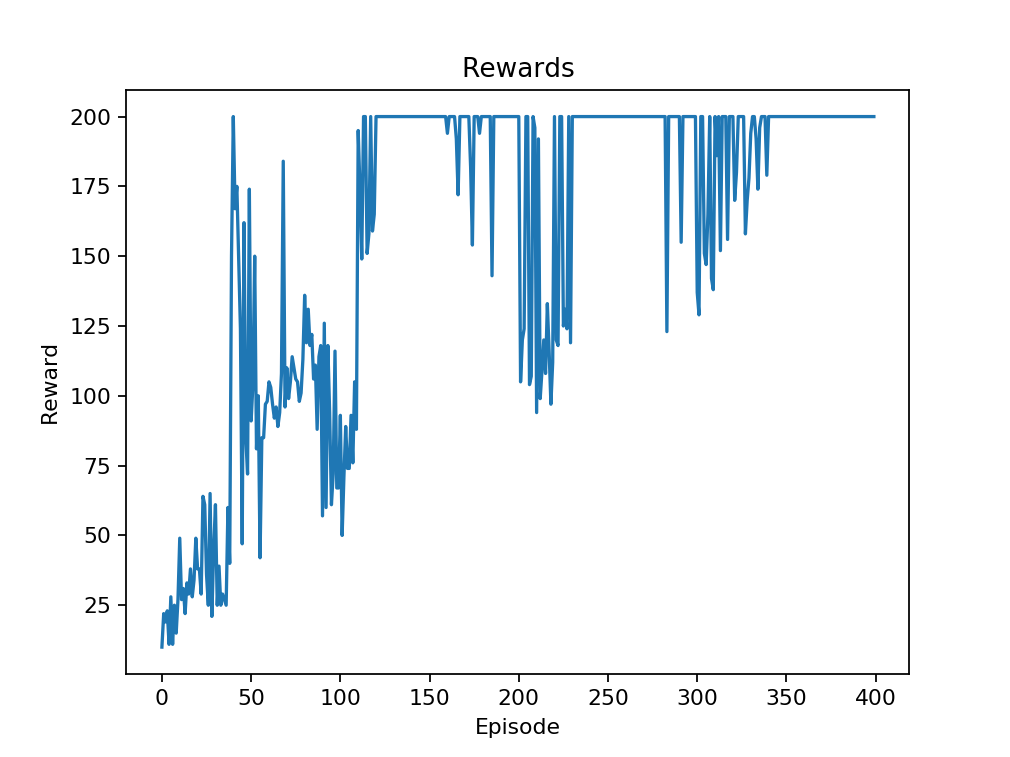

In [10]:
fig, ax = plt.subplots(1)

ax.set_title("Rewards")
ax.set_xlabel("Episode")
ax.set_ylabel("Reward")

ax.plot(rewards_cache)

This solution is brought to you by Lukas Braun. If you have any questions or comments, please do not hesitate to contact lbraun@uos.de